## Graph Analytics Demo

In this demo we will using encrypted graphs and PageRank to show how employee reviews can be mined for key insights, all while keeping sensitive information private. The scenario is as follows: 

* Each employee is invited to review 5 of their colleagues that they have directly worked with. 
* Each review allows an employee to rate their colleagues an integer value in the range [1,5], where 1 is extremely negative, and 5 is extremely postive.
* In this simplified scenario a dataframe is created via employee submissions. The dataframe is then used to calculate average ratings for each employee, which are then encrypted. Additionally, a network graph is created. In this graph, each employee forms a node, and the directed, weighted edge between two employees symbolizes a review.
* Using pagerank, one is able to securely determine key individuals that are vital to the organization: these are people who work many other key employees, who in turn work with lots of other employees. In this sense we are able to enrich the average rating by also ascertaining how integrated an employee is, and therefore wether they are a critical asset to the organization, or even a liability.  


In [3]:
# Import Dependencies
import sys
sys.path.append('..')


In [6]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = 'notebook'
# pio.renderers.default = 'iframe'


In [8]:
from venumML.venumpy import small_glwe as vp
from venumML.graphs.venum_graph import *

from venumML.venum_tools import *

In [9]:
ctx = vp.SecretContext()
ctx.precision = 6

Let's import the sensitive dataframe of 360 employee reviews.

In [10]:
reviews = pd.read_csv('graph_demo/data/reviews.csv')

In [11]:
reviews.head(10)


,Reviewer,Reviewee,Score,reviewer_role,reviewee_role
0,Allison Hill,Noah Rhodes,4,executive,executive
1,Allison Hill,Jamie Arnold,3,executive,executive
2,Allison Hill,Gina Moore,2,executive,executive
3,Allison Hill,Fred Smith,3,executive,executive
4,Allison Hill,Debra Davidson,5,executive,executive
5,Noah Rhodes,Elizabeth Fowler,1,manager,manager
6,Noah Rhodes,Judy Baker,2,manager,manager
7,Noah Rhodes,Debra Davidson,5,manager,manager
8,Noah Rhodes,Brittany Farmer,4,manager,manager
9,Noah Rhodes,Jamie Arnold,1,manager,manager


Now, let's convert the dataframe into an encrypted graph. The "from node" will be the Reviewer. The "to node" will be the Reviewee. The rating assigned by the Reviewer will act as the weight. In this case, for simplicity, we won't be hashing the nodes.

In [14]:
G = df_to_encrypted_graph(ctx, reviews,from_col='Reviewer',to_col='Reviewee', weight_col= None, use_hashing=False)

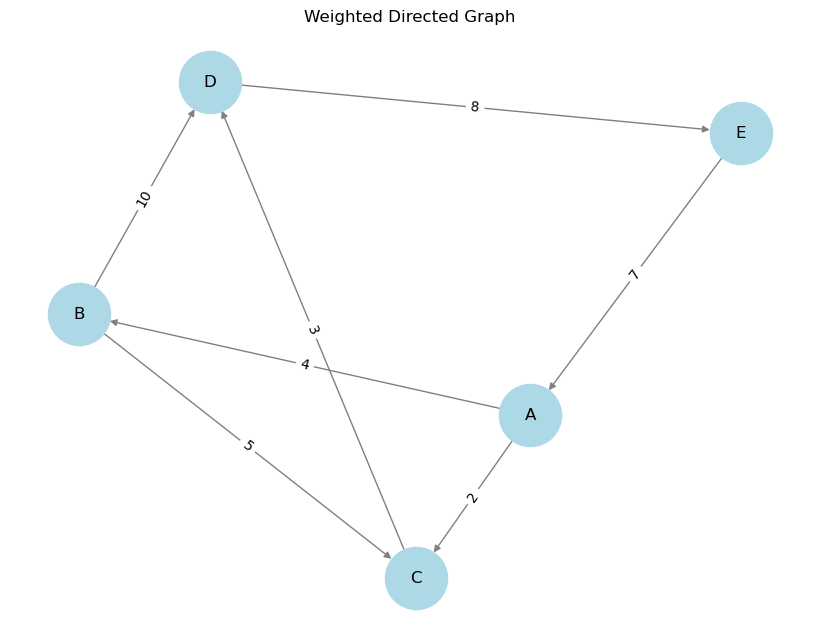

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = ["A", "B", "C", "D", "E"]
G.add_nodes_from(nodes)

# Add weighted edges (directed)
edges = [
    ("A", "B", 4),
    ("A", "C", 2),
    ("B", "C", 5),
    ("B", "D", 10),
    ("C", "D", 3),
    ("D", "E", 8),
    ("E", "A", 7)
]
G.add_weighted_edges_from(edges)

# Draw the graph with weights
pos = nx.spring_layout(G)  # Positioning of nodes
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color='gray', arrows=True)
edge_labels = {(u, v): w for u, v, w in edges}  # Extract weights
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Weighted Directed Graph")
plt.show()

Next, let's calculate the average rating per employee, and store it in a nested dictionary, along with their role. 

In [8]:
# Create a dictionary where the employee is the key and reviewer_role is the value
employee_roles = reviews.set_index('Reviewer')['reviewer_role'].to_dict()

# Calculate the average score per employee, including those who didn't get a review
average_scores = reviews.groupby('Reviewee').apply(lambda x: {'AverageScore': x['Score'].mean(), 'Role': x['reviewer_role'].iloc[0]}).to_dict()

# Add employees who didn't get a review with a score of 0
for employee in employee_roles:
    if employee not in average_scores:
        average_scores[employee] = {'AverageScore': 0, 'Role': employee_roles[employee]}

average_scores

{'Allison Hill': {'AverageScore': 1.5, 'Role': 'manager'},
 'Angelica Tucker': {'AverageScore': 2.0, 'Role': 'executive'},
 'Angie Henderson': {'AverageScore': 4.5, 'Role': 'intern'},
 'Anthony Humphrey': {'AverageScore': 1.5333333333333334, 'Role': 'manager'},
 'Anthony Rodriguez': {'AverageScore': 4.0, 'Role': 'intern'},
 'Brian Ramirez': {'AverageScore': 3.5, 'Role': 'manager'},
 'Brittany Farmer': {'AverageScore': 4.125, 'Role': 'manager'},
 'Carla Gray': {'AverageScore': 2.5, 'Role': 'intern'},
 'Cassandra Gaines': {'AverageScore': 3.0, 'Role': 'manager'},
 'Connie Lawrence': {'AverageScore': 5.0, 'Role': 'manager'},
 'Debra Davidson': {'AverageScore': 5.0, 'Role': 'executive'},
 'Derek Zuniga': {'AverageScore': 3.75, 'Role': 'manager'},
 'Elizabeth Fowler': {'AverageScore': 1.4444444444444444, 'Role': 'manager'},
 'Ethan Adams': {'AverageScore': 2.5, 'Role': 'intern'},
 'Fred Smith': {'AverageScore': 3.0, 'Role': 'executive'},
 'Gabrielle Davis': {'AverageScore': 3.8, 'Role': 'ma

Before transmitting this data for analysis, let's encrypt the data using the secret context we created earlier.

In [9]:
for k in average_scores.keys():
    average_scores[k]['AverageScore'] = ctx.encrypt(average_scores[k]['AverageScore'])

In [10]:
average_scores

{'Allison Hill': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x1695c1670>,
  'Role': 'manager'},
 'Angelica Tucker': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x1695c13a0>,
  'Role': 'executive'},
 'Angie Henderson': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x169760df0>,
  'Role': 'intern'},
 'Anthony Humphrey': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x169760c70>,
  'Role': 'manager'},
 'Anthony Rodriguez': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x169760f10>,
  'Role': 'intern'},
 'Brian Ramirez': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x169760d30>,
  'Role': 'manager'},
 'Brittany Farmer': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x169760ac0>,
  'Role': 'manager'},
 'Carla Gray': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x1697609a0>,
  'Role': 'intern'},
 'Cassandra Gaines': {'AverageScore': <venumML.venumpy.small_glwe.Ciphertext at 0x169760

To keep things streamlined, we will continue the notebook as if we were now in an separate environment, and had imported the encrypted graph and dictionary sent to us.

Let's now run the encrypted graph through our pagerank algorithm. 

In [11]:
encrypted_pagerank = pagerank(ctx, G, iters=20)

In [12]:
encrypted_pagerank

{'Allison Hill': <venumML.venumpy.small_glwe.Ciphertext at 0x169770760>,
 'Noah Rhodes': <venumML.venumpy.small_glwe.Ciphertext at 0x169770700>,
 'Angie Henderson': <venumML.venumpy.small_glwe.Ciphertext at 0x169770670>,
 'Daniel Wagner': <venumML.venumpy.small_glwe.Ciphertext at 0x1697705b0>,
 'Cristian Santos': <venumML.venumpy.small_glwe.Ciphertext at 0x1697704f0>,
 'Connie Lawrence': <venumML.venumpy.small_glwe.Ciphertext at 0x169770460>,
 'Abigail Shaffer': <venumML.venumpy.small_glwe.Ciphertext at 0x169770400>,
 'Gina Moore': <venumML.venumpy.small_glwe.Ciphertext at 0x169770850>,
 'Gabrielle Davis': <venumML.venumpy.small_glwe.Ciphertext at 0x169770340>,
 'Ryan Munoz': <venumML.venumpy.small_glwe.Ciphertext at 0x169770730>,
 'Monica Herrera': <venumML.venumpy.small_glwe.Ciphertext at 0x169770310>,
 'Jamie Arnold': <venumML.venumpy.small_glwe.Ciphertext at 0x1697702b0>,
 'Lisa Hensley': <venumML.venumpy.small_glwe.Ciphertext at 0x169770250>,
 'Michele Williams': <venumML.venumpy.

Now, let's decrypt the PageRank scores.

In [13]:
decrypted_scores = decrypt_pagerank(ctx, encrypted_pagerank)

In [14]:
decrypted_scores

{'Allison Hill': 0.006926997253488505,
 'Noah Rhodes': 0.06604920663049538,
 'Angie Henderson': 0.044038719076206115,
 'Daniel Wagner': 0.0033333,
 'Cristian Santos': 0.0033333,
 'Connie Lawrence': 0.014369945568009652,
 'Abigail Shaffer': 0.0033333,
 'Gina Moore': 0.046779864834017845,
 'Gabrielle Davis': 0.017239434843304056,
 'Ryan Munoz': 0.012981789542089794,
 'Monica Herrera': 0.0033333,
 'Jamie Arnold': 0.07547513023576041,
 'Lisa Hensley': 0.0445018638567776,
 'Michele Williams': 0.006451369190201246,
 'Dylan Miller': 0.0033333,
 'Brian Ramirez': 0.010283826764989826,
 'Holly Wood': 0.0033333,
 'Derek Zuniga': 0.022109412930329603,
 'Lisa Jackson': 0.018155096818007827,
 'Carla Gray': 0.01338839876485492,
 'Margaret Hawkins DDS': 0.0070415339315744495,
 'Patty Perez': 0.01405139213485492,
 'Ethan Adams': 0.004466622,
 'Tommy Walter': 0.039228379393603546,
 'Matthew Foster': 0.0043060462309591945,
 'Judy Baker': 0.06429496032466171,
 'Justin Baker': 0.0033333,
 'Stephanie Ross':

Let's also decrypt the average review ratings.

In [15]:
# Decrypt the average scores
decrypted_average_scores = {k: {'AverageScore': ctx.decrypt(v['AverageScore']), 'Role': v['Role']} for k, v in average_scores.items()}

# Convert the decrypted average scores to a DataFrame
average_scores_df = pd.DataFrame.from_dict(decrypted_average_scores, orient='index')


Next, we'd like to merge that with the pagerank scores to make it simple to plot and analyze our data

In [16]:
# Create DataFrames from average_scores and decrypted_pagerank
decrypted_pagerank_df = pd.DataFrame.from_dict(decrypted_scores, orient='index', columns=['PageRank'])

# Merge the two DataFrames on the index (employee name)
performance_metrics = average_scores_df.merge(decrypted_pagerank_df, left_index=True, right_index=True)

# Reset the index to make employee names a column
performance_metrics.reset_index(inplace=True)
performance_metrics.rename(columns={'index': 'Employee'}, inplace=True)

performance_metrics.head()


,Employee,AverageScore,Role,PageRank
0,Allison Hill,1.500000,manager,0.006927
1,Angelica Tucker,2.000000,executive,0.009552
2,Angie Henderson,4.500000,intern,0.044039
3,Anthony Humphrey,1.533333,manager,0.078132
4,Anthony Rodriguez,4.000000,intern,0.003900


The PageRank combined with the Average rating can be used to cluster employees into three groups of high impact, medium impact and low impact employees.

In [17]:
# Perform K-Means clustering
num_clusters = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
performance_metrics['Cluster'] = kmeans.fit_predict(performance_metrics[['PageRank', 'AverageScore']])


Now let's plot the results! In the below graph, the employees pagerank is represented by the size of their marker. The colour indicates the average rating that they recieved, and the shape symbolizes the cluster they belong to. On the x-axis we have the PageRank, on the y axis we have the average rating.

In [18]:
# Set marker sizes based on PageRank, scaled for visualization
pagerank_min, pagerank_max = performance_metrics['PageRank'].min(), performance_metrics['PageRank'].max()
performance_metrics['MarkerSize'] = 10 + 50 * ((performance_metrics['PageRank'] - pagerank_min) / (pagerank_max - pagerank_min))


# Define the cmin and cmax for consistent color scaling with the network graph
score_min = performance_metrics['AverageScore'].min()
score_max = performance_metrics['AverageScore'].max()

# Plot the clusters using Plotly, with AverageScore for color, PageRank for size, and Role for symbol
fig = px.scatter(
    performance_metrics,
    x='PageRank',
    y='AverageScore',
    color='AverageScore',
    size='MarkerSize',
    color_continuous_scale='RdBu',  # Same color scale as the network graph, reversed
    symbol='Cluster',  # Different markers for each role
    hover_data={
        'Employee': True,
        'PageRank': ':.4f',
        'AverageScore': ':.2f',
        'Role': True,  # Display the role in hover text
        'MarkerSize': False  # Hide MarkerSize in hover text
    },
    title="Employee Impact Based on PageRank and Average Rating",
    labels={'PageRank': 'PageRank', 'AverageScore': 'Average Rating'}
)

# Indent the title to the right
fig.update_layout(title={'x': 0.5})  

# Apply cmin and cmax for consistent color range with the network graph
fig.update_traces(marker=dict(colorbar=dict(title="Average Rating"), cmin=score_min, cmax=score_max))

# Hide the Role legend
fig.update_layout(
    showlegend=False
)

# Show the plot
fig.show()


Let's examine the above graph.
* Noah Rhodes is the highest ranking employee according to PageRank. This makes sense. He's an executive and interfaces with many employees at the company. According to his average score he seems to be well-liked.
* Sherry Decker is an intern, and unfortunately is the lowest ranked. This is because nobody reviewed Sherry, highlighting a flaw in the 360 review system. HR should solicite reviews on her behalf, as her current score of 0 is not even a valid option. Meanwhile, Anthony Rodriguez has been recognized for a very successful internship.
* Jamie Arnold is a high ranking executive who is scoring poorly on his 360 performance reviews. Their peformance may require further examination by the CEO.